In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tikzplotlib as tikz
import os
from scipy.integrate import solve_ivp
from scipy.stats import sem

from models import *
import stars

from stars.rto.master_vkc import MasterVKC
from stars.rto.reactions import Component, Kinetics

%load_ext autoreload
%autoreload 2

# Generate Synthetic Data

Use Cinar (2011) reaction model: 
\begin{align*}
1.0 Oil + 4.00 O_2 &\rightarrow 10.00 Coke_1 + 22.389 H_2O  \\
1.0 Coke_1 + 1.50 O_2 &\rightarrow 1.0CO + 1.0 CO_2  \\
1.0 Coke_1 &\rightarrow 2.0 Coke_2 \\
1.0 Coke_2 + 1.4375 O_2 &\rightarrow 0.5 CO + 1.0 CO_2
\end{align*}
from Ogunbanwo (2018).

Run dense sampling of heating rates from 2.0 to 30.0.


In [2]:
# Setup parameters for all runs

TFINAL = 300
TEMP_MAX = 750
T0 = 15.0
O2_init = 0.21
So = 0.1

IC_dict = {'Oil': So, 'O2': O2_init, 'Temp': T0}
exe_path = '"C:\\Program Files (x86)\\CMG\\STARS\\2017.10\\Win_x64\\EXE\\st201710.exe"'

# Build STARS reactions
comp_names = ['Oil', 'Coke1', 'Coke2', 'O2', 'H2O', 'CO', 'CO2']
stars_components = stars.get_component_dict(comp_names)

REAC_COEFFS = np.array([[1.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0, 1.5, 0.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                       [0.0, 0.0, 1.0, 1.4375, 0.0, 0.0, 0.0]])
PROD_COEFFS = np.array([[0.0, 10.0, 0.0, 0.0, 22.389, 0.0, 0.0],
                       [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0],
                       [0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0],
                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 1.0]])
REAC_ORDERS = 1.0*np.greater(REAC_COEFFS,0)
PREEXP_FAC = [1e-1, 2.5e3, 2.5e3, 2e-2]
ACT_ENERGY = [2.3e4, 6.7e4, 7.0e4, 9.5e4]
RENTH = [5.97e5, 1e6, 0.0, 4.85e6]

# Assemble STARS reactions list
req_comps = ['Oil', 'O2', 'H2O', 'CO', 'CO2', 'N2'] # required components
comp_names_aug = comp_names + [c for c in req_comps if c not in comp_names]
phases = [stars_components[c].phase for c in comp_names_aug] # get phases
comp_names_srtd = [c for _, c in sorted(zip(phases, comp_names_aug))] # sort comp_names according to phase
comp_names_inds = [comp_names_aug.index(c) for c in comp_names_srtd]

stars_reactions = []
num_pad = len(comp_names_aug) - len(comp_names)
for i in range(4):
    storeac = np.pad(REAC_COEFFS[i,:],(0,num_pad))
    stoprod = np.pad(PROD_COEFFS[i,:],(0,num_pad))
    rorder = np.pad(REAC_ORDERS[i,:],(0,num_pad))

    stars_reactions.append(stars.Kinetics(NAME="RXN"+str(i+1),
                            STOREAC=storeac[comp_names_inds].tolist(),
                            STOPROD=stoprod[comp_names_inds].tolist(),
                            RORDER=rorder[comp_names_inds].tolist(),
                            FREQFAC=PREEXP_FAC[i], 
                            EACT=ACT_ENERGY[i],
                            RENTH=RENTH[i])
                            )
    

In [7]:
# Run regular linear heating curves

hrs = [2.0*(i+1) for i in range(15)]
Time = np.arange(0,TFINAL,1)

# Run STARS simulation
for i, hr in enumerate(hrs):
    
    Temp_max = TEMP_MAX
    print('Running heating schedule {} with heating rate={} and T_max={}...'.format(str(i), str(hr), str(Temp_max)))
    
    Temp = np.minimum(hr*Time+IC_dict['Temp'], Temp_max)
    HEATING_DATA = {'Time': Time, 'Temp': Temp}
    
    cd_path = os.path.join('datasets','synthetic','ramp_vanilla','schedule_'+str(i+1))
    if not os.path.exists(cd_path):
        os.makedirs(cd_path)
    kc = MasterVKC(folder_name = os.path.join(cd_path,''))
    write_dict = {
                'COMPS': stars_components, 
                'REACTS': stars_reactions, 
                'IC_dict': IC_dict, 
                'HEATING_DATA': HEATING_DATA,
                'TFINAL': HEATING_DATA['Time'][-1],
                'O2_con_in': IC_dict['O2']
                }
    
    kc.write_dat_file(**write_dict)
    kc.run_dat_file(exe_path, cd_path)
    
    # Save effluence data
    t, ydict = kc.get_reaction_dict()
    df_out = pd.DataFrame()
    df_out['Time'] = t*60
    df_out['Oil'] = ydict['Oil']
    df_out['O2'] = ydict['O2']
    df_out['H2O'] = ydict['H2O']
    df_out['CO'] = ydict['CO']
    df_out['CO2'] = ydict['CO2']
    df_out['N2'] = ydict['N2']
    df_out['Temp'] = ydict['Temp']
    df_out.to_excel(os.path.join('datasets','synthetic','ramp_vanilla', 'schedule_'+str(i+1) + '.xls'))
    
    # Print effluence and temperature data to figures
    plt.plot(t, ydict['O2']*100)
    plt.plot(t, ydict['CO']*100)
    plt.plot(t, ydict['CO2']*100)
    plt.plot(t, ydict['N2']*100)
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [% mol]')
    plt.title('Effluence - Schedule #' + str(i+1))
    plt.legend(['O2', 'CO', 'CO2', 'N2'])
    plt.savefig(os.path.join(cd_path, 'effluence.png'))
    plt.close()
    
    plt.plot(t, ydict['Temp'])
    plt.xlabel('Time [min]')
    plt.ylabel('Temperature [C]')
    plt.title('Temperature -Schedule #'+str(i+1))
    plt.savefig(os.path.join(cd_path, 'temperature.png'))
    plt.close()

Running heating schedule 0 with heating rate=2.0 and T_max=750...
Running heating schedule 1 with heating rate=4.0 and T_max=750...
Running heating schedule 2 with heating rate=6.0 and T_max=750...
Running heating schedule 3 with heating rate=8.0 and T_max=750...
Running heating schedule 4 with heating rate=10.0 and T_max=750...
Running heating schedule 5 with heating rate=12.0 and T_max=750...
Running heating schedule 6 with heating rate=14.0 and T_max=750...
Running heating schedule 7 with heating rate=16.0 and T_max=750...
Running heating schedule 8 with heating rate=18.0 and T_max=750...
Running heating schedule 9 with heating rate=20.0 and T_max=750...
Running heating schedule 10 with heating rate=22.0 and T_max=750...
Running heating schedule 11 with heating rate=24.0 and T_max=750...
Running heating schedule 12 with heating rate=26.0 and T_max=750...
Running heating schedule 13 with heating rate=28.0 and T_max=750...
Running heating schedule 14 with heating rate=30.0 and T_max=7

In [6]:
# Run ramp-hold heating curves

hrs = [2.0*(i+1) for i in range(15)]
Time = np.arange(0,TFINAL,1)

# Run STARS simulation
for i, hr in enumerate(hrs):
    
    Temp_max = 180 + 19*hr
    print('Running heating schedule {} with heating rate={} and T_max={}...'.format(str(i), str(hr), str(Temp_max)))
    
    Temp = np.minimum(hr*Time+IC_dict['Temp'], Temp_max)
    HEATING_DATA = {'Time': Time, 'Temp': Temp}
    
    cd_path = os.path.join('datasets','synthetic','ramp_hold','schedule_'+str(i+1))
    if not os.path.exists(cd_path):
        os.makedirs(cd_path)
    kc = MasterVKC(folder_name = os.path.join(cd_path,''))
    
    write_dict = {
                'COMPS': stars_components, 
                'REACTS': stars_reactions, 
                'IC_dict': IC_dict, 
                'HEATING_DATA': HEATING_DATA,
                'TFINAL': HEATING_DATA['Time'][-1],
                'O2_con_in': IC_dict['O2']
                }
    
    kc.write_dat_file(**write_dict)
    kc.run_dat_file(exe_path, cd_path)
    
    # Save effluence data
    t, ydict = kc.get_reaction_dict()
    df_out = pd.DataFrame()
    df_out['Time'] = t*60
    df_out['Oil'] = ydict['Oil']
    df_out['O2'] = ydict['O2']
    df_out['H2O'] = ydict['H2O']
    df_out['CO'] = ydict['CO']
    df_out['CO2'] = ydict['CO2']
    df_out['N2'] = ydict['N2']
    df_out['Temp'] = ydict['Temp']
    df_out.to_excel(os.path.join('datasets','synthetic','ramp_hold', 'schedule_'+str(i+1) + '.xls'))
    
    # Print effluence and temperature data to figures
    plt.plot(t, ydict['O2']*100)
    plt.plot(t, ydict['CO']*100)
    plt.plot(t, ydict['CO2']*100)
    plt.plot(t, ydict['N2']*100)
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [% mol]')
    plt.title('Effluence - Schedule #' + str(i+1))
    plt.legend(['O2', 'CO', 'CO2', 'N2'])
    plt.savefig(os.path.join(cd_path, 'effluence.png'))
    plt.close()
    
    plt.plot(t, ydict['Temp'])
    plt.xlabel('Time [min]')
    plt.ylabel('Temperature [C]')
    plt.title('Temperature - Schedule #'+str(i+1))
    plt.savefig(os.path.join(cd_path, 'temperature.png'))
    plt.close()

Running heating schedule 0 with heating rate=2.0 and T_max=218.0...
Running heating schedule 1 with heating rate=4.0 and T_max=256.0...
Running heating schedule 2 with heating rate=6.0 and T_max=294.0...
Running heating schedule 3 with heating rate=8.0 and T_max=332.0...
Running heating schedule 4 with heating rate=10.0 and T_max=370.0...
Running heating schedule 5 with heating rate=12.0 and T_max=408.0...
Running heating schedule 6 with heating rate=14.0 and T_max=446.0...
Running heating schedule 7 with heating rate=16.0 and T_max=484.0...
Running heating schedule 8 with heating rate=18.0 and T_max=522.0...
Running heating schedule 9 with heating rate=20.0 and T_max=560.0...
Running heating schedule 10 with heating rate=22.0 and T_max=598.0...
Running heating schedule 11 with heating rate=24.0 and T_max=636.0...
Running heating schedule 12 with heating rate=26.0 and T_max=674.0...
Running heating schedule 13 with heating rate=28.0 and T_max=712.0...
Running heating schedule 14 with h

In [8]:
# Run ramp-unramp-ramp heating curves

hrs = [2.0*(i+1) for i in range(15)]
Time = np.arange(0,TFINAL,1)

# Run STARS simulation
for i, hr in enumerate(hrs):
    print('Running heating schedule {}...'.format(str(hr)))
    
    Temp_max = 180 + 19*hr
    t_ramp = int(np.round(0.95*Temp_max/hr)) # ramp up to maximum temperature
    t_unramp = int(np.round(0.25*t_ramp)) # unramp for 25% of ramping time by -5 / HR
    t_end = int(np.round(TFINAL - t_ramp - t_unramp)) # ramp back up to maximum temperature
    hr_array = [hr]*t_ramp + [-5 / hr]*t_unramp + [hr]*t_end
    
    Temp = np.minimum(cumtrapz(hr_array, Time, initial=IC_dict['Temp']), Temp_max)
    HEATING_DATA = {'Time': Time, 'Temp': Temp}
    
    cd_path = os.path.join('datasets','synthetic','ramp_unramp_ramp','schedule_'+str(i+1))
    if not os.path.exists(cd_path):
        os.makedirs(cd_path)
    kc = MasterVKC(folder_name = os.path.join(cd_path,''))
    write_dict = {
                'COMPS': stars_components, 
                'REACTS': stars_reactions, 
                'IC_dict': IC_dict, 
                'HEATING_DATA': HEATING_DATA,
                'TFINAL': HEATING_DATA['Time'][-1],
                'O2_con_in': IC_dict['O2']
                }
    
    kc.write_dat_file(**write_dict)
    kc.run_dat_file(exe_path, cd_path)
    
    # Save effluence data
    t, ydict = kc.get_reaction_dict()
    df_out = pd.DataFrame()
    df_out['Time'] = t*60
    df_out['Oil'] = ydict['Oil']
    df_out['O2'] = ydict['O2']
    df_out['H2O'] = ydict['H2O']
    df_out['CO'] = ydict['CO']
    df_out['CO2'] = ydict['CO2']
    df_out['N2'] = ydict['N2']
    df_out['Temp'] = ydict['Temp']
    df_out.to_excel(os.path.join('datasets','synthetic','ramp_unramp_ramp', 'schedule_'+str(i+1) + '.xls'))
    
    # Print effluence and temperature data to figures
    plt.plot(t, ydict['O2']*100)
    plt.plot(t, ydict['CO']*100)
    plt.plot(t, ydict['CO2']*100)
    plt.plot(t, ydict['N2']*100)
    plt.xlabel('Time [min]')
    plt.ylabel('Concentration [% mol]')
    plt.title('Effluence - Schedule #' + str(i+1))
    plt.legend(['O2', 'CO', 'CO2', 'N2'])
    plt.savefig(os.path.join(cd_path, 'effluence.png'))
    plt.close()
    
    plt.plot(t, ydict['Temp'])
    plt.xlabel('Time [min]')
    plt.ylabel('Temperature [C]')
    plt.title('Temperature -Schedule #'+str(i+1))
    plt.savefig(os.path.join(cd_path, 'temperature.png'))
    plt.close()

Running heating schedule 2.0...
Running heating schedule 4.0...
Running heating schedule 6.0...
Running heating schedule 8.0...
Running heating schedule 10.0...
Running heating schedule 12.0...
Running heating schedule 14.0...
Running heating schedule 16.0...
Running heating schedule 18.0...
Running heating schedule 20.0...
Running heating schedule 22.0...
Running heating schedule 24.0...
Running heating schedule 26.0...
Running heating schedule 28.0...
Running heating schedule 30.0...


# Make Plots for Different Proposed Heating Schedules

Minimum conversion rate: 0.0, maximum conversion rate: 0.33539889135630874


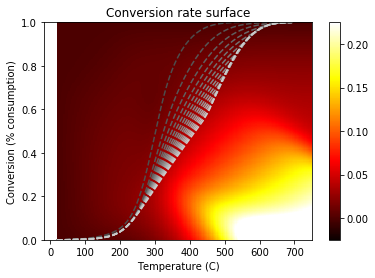

Minimum log-std. dev.: -10.489681060407111, maximum log-std. dev.: -4.809255652912355


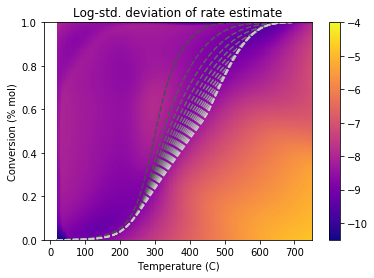

Minimum conversion rate: 0.0, maximum conversion rate: 0.35832258350819257


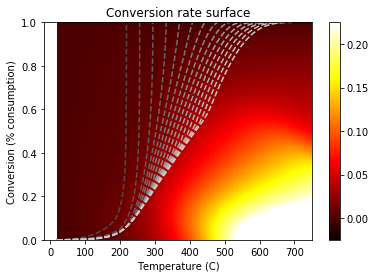

Minimum log-std. dev.: -10.230348333898093, maximum log-std. dev.: -4.941496050395011


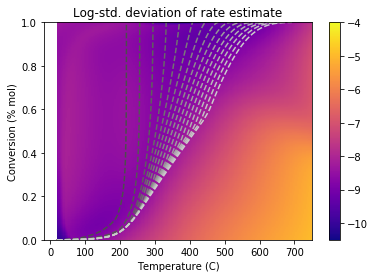

Minimum conversion rate: 0.0, maximum conversion rate: 0.36967266700544243


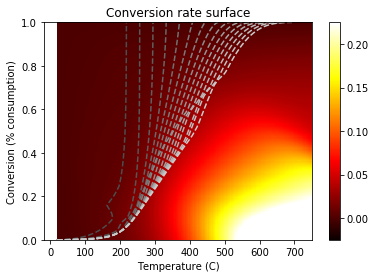

Minimum log-std. dev.: -10.17639884632151, maximum log-std. dev.: -4.890628297079323


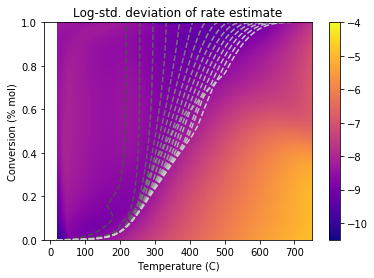

In [2]:
result_dir = os.path.join('results','experimental_design')
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

# # Print surfaces for ramp-hold curves
ramp_vanilla_container = NonArrheniusML(oil_type='synthetic', experiment='ramp_vanilla', clean_data=False)
ramp_vanilla_container.print_surf_plot(save_path = os.path.join(result_dir, 'ramp_vanilla_surf.png'),
                                       vmin=-0.025,
                                       vmax=0.225,
                                       legend=False)
ramp_vanilla_container.print_uncertainty_surf(save_path = os.path.join(result_dir, 'ramp_vanilla_uncertainty.png'),
                                              vmin=-10.5,
                                              vmax=-4,
                                              legend=False)

# Print surfaces for ramp-hold curves
ramp_hold_container = NonArrheniusML(oil_type='synthetic', experiment='ramp_hold', clean_data=False)
ramp_hold_container.print_surf_plot(save_path = os.path.join(result_dir, 'ramp_hold_surf.png'),
                                    vmin=-0.025,
                                    vmax=0.225, 
                                    legend=False)
ramp_hold_container.print_uncertainty_surf(save_path = os.path.join(result_dir, 'ramp_hold_uncertainty.png'),
                                           vmin=-10.5,
                                           vmax=-4, 
                                           legend=False)

# Print surfaces for ramp-unramp-ramp curves
unramp_hold_container = NonArrheniusML(oil_type='synthetic', experiment='ramp_unramp_ramp', clean_data=False)
unramp_hold_container.print_surf_plot(save_path = os.path.join(result_dir, 'ramp_unramp_ramp_surf.png'),
                                      vmin=-0.025,
                                      vmax=0.225,
                                      legend=False)
unramp_hold_container.print_uncertainty_surf(save_path = os.path.join(result_dir, 'ramp_unramp_ramp_uncertainty.png'),
                                             vmin=-10.5,
                                             vmax=-4,
                                             legend=False)

In [4]:
random_container =  NonArrheniusInterp(oil_type='synthetic', experiment='random_curves', clean_data=False)

#### Run error estimate for regular linear heating rates

In [11]:
# Compute MSEs for vanilla RTO curves

np.random.seed(999)

MAX_NUMBER_EXPERIMENTS = 10
NUMBER_TRIALS = 10

MSE_interp_dict_vanilla = {}
MSE_mlc_dict_vanilla = {}


for num_heats in range(2,MAX_NUMBER_EXPERIMENTS+1, 2):
    print('Running for {} selected heating rates...'.format(str(num_heats)))
    
    # Simulate and collect MSEs
    MSEs_interp_vanilla, MSEs_ml_vanilla, MSEs_mlc_vanilla = [], [], []
    
    for t in range(NUMBER_TRIALS):
        print('Running trial {} for vanilla RTO data models...'.format(str(t+1)))
        # Choose heating rates
        selected_hrs = np.random.choice(np.arange(1,16),num_heats,replace=False).tolist()
        selected_hrs = ['schedule_'+str(int(hr)) for hr in selected_hrs]

        # Build prediction models
        nainterp = NonArrheniusInterp(oil_type='synthetic', experiment='ramp_vanilla', 
                                    clean_data=False, heating_rates=selected_hrs)
        naml_const = NonArrheniusML(oil_type='synthetic', experiment='ramp_vanilla', 
                                    clean_data=False, heating_rates=selected_hrs, constrained=True)

        # Compute error across all extrapolated heating rates
        MSE_interp, MSE_ml, MSE_mlc = 0, 0, 0
        for i, hr in enumerate(random_container.heating_rates):
            # Load data
            Time = random_container.Times[i,:]
            Temp = random_container.Temps[i,:]
            O2 = random_container.O2convs[i,:]

            # Run simulations
            y0=[0.0]
            tspan=[Time[0], Time[-1]]
            heating=[Time, Temp]
            t_interp, y_interp = nainterp.simulate_rto(y0, tspan, heating, max_temp=Temp.max())
            O2_interp = np.interp(Time, t_interp, np.squeeze(y_interp))
            MSE_interp += nainterp.compute_sim_mse({'Time': Time, 'Temp': Temp, 'O2conv': O2},
                                                  {'Time': Time, 'O2conv': O2_interp})
            t_mlc, y_mlc = naml_const.simulate_rto(y0, tspan, heating, max_temp=Temp.max())
            O2_ml = np.interp(Time, t_mlc, np.squeeze(y_mlc))
            MSE_mlc += naml_const.compute_sim_mse({'Time': Time, 'Temp': Temp, 'O2conv': O2},
                                                {'Time': Time, 'O2conv': O2_ml})

        # Log for iteration
        MSEs_interp_vanilla.append(MSE_interp)
        MSEs_mlc_vanilla.append(MSE_mlc)
    
    # Record trials for MSE in dictionaries
    MSE_interp_dict_vanilla[num_heats] = MSEs_interp_vanilla
    MSE_mlc_dict_vanilla[num_heats] = MSEs_mlc_vanilla
    

Running for 2 selected heating rates...
Running trial 1 for vanilla RTO data models...
Running trial 2 for vanilla RTO data models...
Running trial 3 for vanilla RTO data models...
Running trial 4 for vanilla RTO data models...


LinAlgError: Singular matrix

In [ ]:
# Output dictionaries of simulation data
print(MSE_interp_dict_vanilla)
print(MSE_mlc_dict_vanilla)


In [ ]:
# Make plot

exp_nums = [2, 4, 6, 8, 10] # Number of experiments

interp_means = [np.mean(MSE_interp_dict_vanilla[i]) for i in exp_nums] 
interp_sems = [sem(MSE_interp_dict_vanilla[i]) for i in exp_nums] 
plt.errorbar(exp_nums,interp_means,yerr=interp_sems,label='Interpolation',marker='o', capsize=4)

mlc_means = [np.mean(MSE_mlc_dict_vanilla[i]) for i in exp_nums] 
mlc_sems = [sem(MSE_mlc_dict_vanilla[i]) for i in exp_nums] 
plt.errorbar(exp_nums,mlc_means,yerr=mlc_sems,label='NAMLA',marker='o', capsize=4)

plt.xlabel('Number of RTO experiments')
plt.ylabel('Total MSE of estimated solutions')
plt.title('Linear Heating Rates Error Plot')
plt.legend(loc='upper right')
plt.savefig(os.path.join('results','experimental_design','vanilla_error.png'))
plt.show()



#### Run for ramp-hold heating curves

In [ ]:
# Compute MSEs for ramp-hold RTO curves

np.random.seed(999)

MAX_NUMBER_EXPERIMENTS = 10
NUMBER_TRIALS = 30

MSE_interp_dict_ramp = {}
# MSE_ml_dict_ramp = {}
MSE_mlc_dict_ramp = {}


for num_heats in range(2,MAX_NUMBER_EXPERIMENTS+1, 2):
    print('Running for {} selected heating rates...'.format(str(num_heats)))
    
    # Simulate and collect MSEs
    MSEs_interp_ramp, MSEs_ml_ramp, MSEs_mlc_ramp = [], [], []
    t = 0
    for t in range(NUMBER_TRIALS):
        print('Running trial {} for ramp-hold RTO data models...'.format(str(t+1)))
        # Choose heating rates
        selected_hrs = np.random.choice(np.arange(1,16),num_heats,replace=False).tolist()
        selected_hrs = ['schedule_'+str(int(hr)) for hr in selected_hrs]

        # Build prediction models
        nainterp = NonArrheniusInterp(oil_type='synthetic', experiment='ramp_hold', 
                                    clean_data=False, heating_rates=selected_hrs)
        naml_const = NonArrheniusML(oil_type='synthetic', experiment='ramp_hold', 
                                    clean_data=False, heating_rates=selected_hrs, constrained=True)

        # Compute error across all extrapolated heating rates
        MSE_interp, MSE_ml, MSE_mlc = 0, 0, 0
        for i, hr in enumerate(random_container.heating_rates):
            # Load data
            Time = random_container.Times[i,:]
            Temp = random_container.Temps[i,:]
            O2 = random_container.O2convs[i,:]

            # Run simulations
            y0=[0.0]
            tspan=[Time[0], Time[-1]]
            heating=[Time, Temp]
            t_interp, y_interp = nainterp.simulate_rto(y0, tspan, heating, max_temp=Temp.max())
            O2_interp = np.interp(Time, t_interp, np.squeeze(y_interp))
            MSE_interp += nainterp.compute_sim_mse({'Time': Time, 'Temp': Temp, 'O2conv': O2},
                                                  {'Time': Time, 'O2conv': O2_interp})
            t_mlc, y_mlc = naml_const.simulate_rto(y0, tspan, heating, max_temp=Temp.max())
            O2_ml = np.interp(Time, t_mlc, np.squeeze(y_mlc))
            MSE_mlc += naml_const.compute_sim_mse({'Time': Time, 'Temp': Temp, 'O2conv': O2},
                                                {'Time': Time, 'O2conv': O2_ml})

        # Log for iteration
        MSEs_interp_ramp.append(MSE_interp)
        MSEs_mlc_ramp.append(MSE_mlc)
    
    # Record trials for MSE in dictionaries
    MSE_interp_dict_ramp[num_heats] = MSEs_interp_ramp
    MSE_mlc_dict_ramp[num_heats] = MSEs_mlc_ramp
    

In [ ]:
# Output dictionaries of simulation data
print(MSE_interp_dict_ramp)
print(MSE_mlc_dict_ramp)


In [ ]:
# Make plot

exp_nums = [2, 4, 6, 8, 10] # Number of experiments

interp_means = [np.mean(MSE_interp_dict_ramp[i]) for i in exp_nums] 
interp_sems = [sem(MSE_interp_dict_ramp[i]) for i in exp_nums] 
plt.errorbar(exp_nums,interp_means,yerr=interp_sems,label='Interpolation',marker='o', capsize=4)

mlc_means = [np.mean(MSE_mlc_dict_ramp[i]) for i in exp_nums] 
mlc_sems = [sem(MSE_mlc_dict_ramp[i]) for i in exp_nums] 
plt.errorbar(exp_nums,mlc_means,yerr=mlc_sems,label='NAMLA',marker='o', capsize=4)

plt.xlabel('Number of RTO experiments')
plt.ylabel('Total MSE of estimated solutions')
plt.title('Ramp-Hold Heating Rates Error Plot')
plt.legend(loc='upper right')
plt.savefig(os.path.join('results','experimental_design','ramp_error.png'))
plt.show()



In [ ]:
# Compute MSEs for ramp-unramp-ramp-hold RTO curves

np.random.seed(999)

MAX_NUMBER_EXPERIMENTS = 10
NUMBER_TRIALS = 30

MSE_interp_dict_unramp = {}
MSE_ml_dict_unramp = {}
MSE_mlc_dict_unramp = {}


for num_heats in range(2,MAX_NUMBER_EXPERIMENTS+1, 2):
    print('Running for {} selected heating rates...'.format(str(num_heats)))
    
    # Simulate and collect MSEs
    MSEs_interp_unramp, MSEs_ml_unramp, MSEs_mlc_unramp = [], [], []
    
    for t in range(NUMBER_TRIALS):
        print('Running trial {} for ramp-hold RTO data models...'.format(str(t+1)))
        # Choose heating rates
        selected_hrs = np.random.choice(np.arange(1,16),num_heats,replace=False).tolist()
        selected_hrs = ['schedule_'+str(int(hr)) for hr in selected_hrs]

        # Build prediction models
        nainterp = NonArrheniusInterp(oil_type='synthetic', experiment='ramp_unramp_ramp', 
                                    clean_data=False, heating_rates=selected_hrs)
        naml_const = NonArrheniusML(oil_type='synthetic', experiment='ramp_unramp_ramp', 
                                    clean_data=False, heating_rates=selected_hrs, constrained=True)

        # Compute error across all extrapolated heating rates
        MSE_interp, MSE_ml, MSE_mlc = 0, 0, 0
        for i, hr in enumerate(random_container.heating_rates):
            # Load data
            Time = random_container.Times[i,:]
            Temp = random_container.Temps[i,:]
            O2 = random_container.O2convs[i,:]

            # Run simulations
            y0=[0.0]
            tspan=[Time[0], Time[-1]]
            heating=[Time, Temp]
            t_interp, y_interp = nainterp.simulate_rto(y0, tspan, heating, max_temp=Temp.max())
            O2_interp = np.interp(Time, t_interp, np.squeeze(y_interp))
            MSE_interp += nainterp.compute_sim_mse({'Time': Time, 'Temp': Temp, 'O2conv': O2},
                                                  {'Time': Time, 'O2conv': O2_interp})
            t_mlc, y_mlc = naml_const.simulate_rto(y0, tspan, heating, max_temp=Temp.max())
            O2_ml = np.interp(Time, t_mlc, np.squeeze(y_mlc))
            MSE_mlc += naml_const.compute_sim_mse({'Time': Time, 'Temp': Temp, 'O2conv': O2},
                                                {'Time': Time, 'O2conv': O2_ml})

        # Log for iteration
        MSEs_interp_unramp.append(MSE_interp)
        MSEs_mlc_unramp.append(MSE_mlc)
    
    # Record trials for MSE in dictionaries
    MSE_interp_dict_unramp[num_heats] = MSEs_interp_unramp
    MSE_mlc_dict_unramp[num_heats] = MSEs_mlc_unramp
    

In [ ]:
# Output dictionaries of simulation data
print(MSE_interp_dict_unramp)
print(MSE_mlc_dict_unramp)


In [ ]:
# Make plot

exp_nums = [2, 4, 6, 8, 10] # Number of experiments

interp_means = [np.mean(MSE_interp_dict_unramp[i]) for i in exp_nums] 
interp_sems = [sem(MSE_interp_dict_unramp[i]) for i in exp_nums] 
plt.errorbar(exp_nums,interp_means,yerr=interp_sems,label='Interpolation',marker='o', capsize=4)

mlc_means = [np.mean(MSE_mlc_dict_unramp[i]) for i in exp_nums] 
mlc_sems = [sem(MSE_mlc_dict_unramp[i]) for i in exp_nums] 
plt.errorbar(exp_nums,mlc_means,yerr=mlc_sems,label='NAMLA',marker='o', capsize=4)

plt.xlabel('Number of RTO experiments')
plt.ylabel('Total MSE of estimated solutions')
plt.title('Ramp-Unramp-Ramp-Hold Heating Rates Error Plot')
plt.legend(loc='upper right')
plt.savefig(os.path.join('results','experimental_design','unramp_error.png'))
plt.show()